# Time-series forecasting using LSTM

In [15]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout 
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

Let us consider four different series S&P 500 (^GSPC), Dow Jones Industrial Average (^DJI), NASDAQ Composite (^IXIC) and Russell 2000 (^RUT) which is Chicago options. Our data set if from 1990 to till date.

In [2]:
stock = ['^RUT', '^GSPC', '^DJI', '^IXIC' ]
start = pd.to_datetime('1990-01-03')
df = web.DataReader(stock, data_source = 'yahoo', start = start )

In [3]:
df

Attributes    Adj Close                                                 Close  \
Symbols            ^RUT        ^GSPC          ^DJI         ^IXIC         ^RUT   
Date                                                                            
1990-01-02   169.949997   359.690002   2810.149902    459.299988   169.949997   
1990-01-03   170.789993   358.760010   2809.729980    460.899994   170.789993   
1990-01-04   170.089996   355.670013   2796.080078    459.399994   170.089996   
1990-01-05   169.649994   352.200012   2773.250000    458.200012   169.649994   
1990-01-08   169.550003   353.790009   2794.370117    458.700012   169.550003   
...                 ...          ...           ...           ...          ...   
2020-08-31  1561.880005  3500.310059  28430.050781  11775.459961  1561.880005   
2020-09-01  1578.579956  3526.649902  28645.660156  11939.669922  1578.579956   
2020-09-02  1592.290039  3580.840088  29100.500000  12056.440430  1592.290039   
2020-09-03  1544.680054  3455.060059  28292.730469  11458.099609  1544.680054   
2020-09-04  1535.303711  3426.959961  28133.310547  11313.134766  1535.303711   

Attributes                                                  High               \
Symbols           ^GSPC          ^DJI         ^IXIC         ^RUT        ^GSPC   
Date                                                                            
1990-01-02   359.690002   2810.149902    459.299988   169.960007   359.690002   
1990-01-03   358.760010   2809.729980    460.899994   170.800003   360.589996   
1990-01-04   355.670013   2796.080078    459.399994   170.789993   358.760010   
1990-01-05   352.200012   2773.250000    458.200012   170.119995   355.670013   
1990-01-08   353.790009   2794.370117    458.700012   169.679993   354.239990   
...                 ...           ...           ...          ...          ...   
2020-08-31  3500.310059  28430.050781  11775.459961  1577.550049  3514.770020   
2020-09-01  3526.649902  28645.660156  11939.669922  1578.579956  3528.030029   
2020-09-02  3580.840088  29100.500000  12056.440430  1595.040039  3588.110107   
2020-09-03  3455.060059  28292.730469  11458.099609  1592.469971  3564.850098   
2020-09-04  3426.959961  28133.310547  11313.134766  1563.380249  3479.149902   

Attributes  ...           Low                       Open               \
Symbols     ...          ^DJI         ^IXIC         ^RUT        ^GSPC   
Date        ...                                                         
1990-01-02  ...   2732.510010    452.700012   168.309998   353.399994   
1990-01-03  ...   2786.260010    460.000000   169.960007   359.690002   
1990-01-04  ...   2766.419922    456.899994   170.779999   358.760010   
1990-01-05  ...   2758.110107    457.799988   170.089996   355.670013   
1990-01-08  ...   2753.409912    456.500000   169.669998   352.200012   
...         ...           ...           ...          ...          ...   
2020-08-31  ...  28363.550781  11697.419922  1577.550049  3509.729980   
2020-09-01  ...  28290.720703  11794.780273  1561.099976  3507.439941   
2020-09-02  ...  28713.529297  11836.179688  1578.780029  3543.760010   
2020-09-03  ...  28074.759766  11361.360352  1592.469971  3564.739990   
2020-09-04  ...  27664.679688  10875.872070  1546.639526  3453.600098   

Attributes                                Volume                         \
Symbols             ^DJI         ^IXIC      ^RUT       ^GSPC       ^DJI   
Date                                                                      
1990-01-02   2748.719971    452.899994   1620700   162070000   20680000   
1990-01-03   2814.199951    461.100006   1923300   192330000   23620000   
1990-01-04   2804.389893    460.399994   1770000   177000000   24370000   
1990-01-05   2786.899902    457.899994   1585300   158530000   20290000   
1990-01-08   2761.729980    457.100006   1401100   140110000   16610000   
...                  ...           ...       ...         ...        ...   
2020-08-31  28643.660156  11718.

Let us fit all the closing prices of the series in a neural network architecture and shall predict one series (NASDAQ composite price) from there.

## Train-test split
We split into train-test and visualize the output.

C:\Users\Johns\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


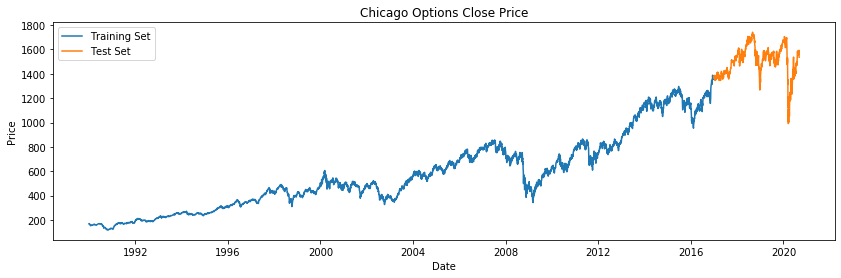

In [4]:
data = df [['Close']]
data = data.reset_index()
training_data = data[data['Date'] < pd.to_datetime('2016-12-31')].copy()
test_data = data[data['Date'] >= pd.to_datetime("2016-12-31")].copy()
training_data = training_data.set_index('Date')
test_data = test_data.set_index('Date')
plt.figure(figsize=(14,4))
plt.plot(training_data.Close['^RUT'])
plt.plot(test_data.Close['^RUT'])
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend(["Training Set", "Test Set"])
plt.title("Chicago Options Close Price")
plt.show()

# Data normalization

Though I have used MinMaxScaler for data standardization. MinMaxScaler rescales the data set such that all feature values are in the range [0, 1]. It normally preserve the shape of the data set. However, data can also be standardized taking the log return as well as shown below. Sometimes standardization using Logreturn provides better result which can also be tried.

In [5]:
df_change=training_data.apply(lambda x: np.log(x) - np.log(x.shift(1)))
df_change.head()

Attributes     Close                              
Symbols         ^RUT     ^GSPC      ^DJI     ^IXIC
Date                                              
1990-01-02       NaN       NaN       NaN       NaN
1990-01-03  0.004930 -0.002589 -0.000149  0.003478
1990-01-04 -0.004107 -0.008650 -0.004870 -0.003260
1990-01-05 -0.002590 -0.009804 -0.008199 -0.002615
1990-01-08 -0.000590  0.004504  0.007587  0.001091

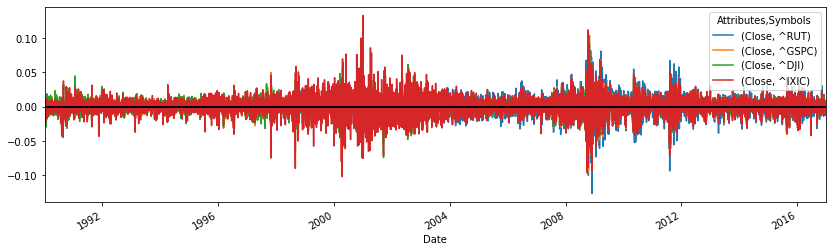

In [6]:
df_change.plot(figsize=(14,4)).axhline(color='black', linewidth=2)
plt.show()

In [7]:
minmax = MinMaxScaler(feature_range = (0, 1))
minmax_single = MinMaxScaler(feature_range = (0, 1))
train_scaled = np.concatenate ([minmax.fit_transform (training_data.Close[['^RUT', '^GSPC', '^DJI']].values), 
                                minmax_single.fit_transform(training_data.Close[['^IXIC']].values)], axis = 1)
train_scaled = pd.DataFrame(train_scaled, columns = training_data.columns) 
train_scaled 

Attributes     Close                              
Symbols         ^RUT     ^GSPC      ^DJI     ^IXIC
0           0.040284  0.032501  0.025273  0.025939
1           0.040945  0.032030  0.025249  0.026249
2           0.040394  0.030467  0.024474  0.025959
3           0.040047  0.028711  0.023178  0.025726
4           0.039968  0.029515  0.024377  0.025823
...              ...       ...       ...       ...
6800        0.986953  0.995987  0.997683  0.995205
6801        0.991838  0.998563  0.998320  1.000000
6802        0.978539  0.988969  0.991996  0.990531
6803        0.980390  0.988635  0.991207  0.989277
6804        0.975623  0.983358  0.987960  0.979791

[6805 rows x 4 columns]

In [8]:
train_scaled.describe() # validating min & max values

Attributes        Close                                       
Symbols            ^RUT        ^GSPC         ^DJI        ^IXIC
count       6805.000000  6805.000000  6805.000000  6805.000000
mean           0.357621     0.410949     0.413415     0.358729
std            0.239788     0.249175     0.248107     0.248153
min            0.000000     0.000000     0.000000     0.000000
25%            0.177034     0.196290     0.199452     0.172095
50%            0.302691     0.427307     0.447451     0.334139
75%            0.508474     0.549523     0.559668     0.468689
max            1.000000     1.000000     1.000000     1.000000

# Shaping data for LSTM

In [9]:
train_scaled = train_scaled.values
n_lags = int(60)
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
  X_train.append(train_scaled[i-n_lags:i])
  y_train.append(train_scaled[i,0])


X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))


# Check the shape (again) before start training
shape_chk = []
for i in stock:
  index = {}
  index["X_train"] = X_train.shape
  index["y_train"] = y_train.shape
  shape_chk.append(index)
  
pd.DataFrame(shape_chk, index=stock)

,X_train,y_train
^RUT,"(6745, 60, 4)","(6745,)"
^GSPC,"(6745, 60, 4)","(6745,)"
^DJI,"(6745, 60, 4)","(6745,)"
^IXIC,"(6745, 60, 4)","(6745,)"


# LSTM network

We will feed the data from 1990 till 2015 to train our network architecture.

In [10]:
%%time

# The LSTM architecture
regressor = Sequential()

# 1st layer with Dropout regularisation
regressor.add(LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1],4)))
regressor.add(Dropout(0.2))

# 2nd LSTM layer
regressor.add(LSTM(units=20, return_sequences=True))
regressor.add(Dropout(0.2))

# 3rd LSTM layer
regressor.add(LSTM(units=20, return_sequences=True))
regressor.add(Dropout(0.5))

# 4th LSTM layer
regressor.add(LSTM(units=20))
regressor.add(Dropout(0.5))

# Output layer
regressor.add(Dense(units=1))

# Compiling LSTM 
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Fitting to the training set

for i in stock:
  print("Fitting to", i)
  regressor.fit(X_train, y_train, epochs=10, batch_size=100)

Fitting to ^RUT
Epoch 1/10
68/68 [==============================] - 8s 119ms/step - loss: 0.0295
Epoch 2/10
68/68 [==============================] - 8s 124ms/step - loss: 0.0130
Epoch 3/10
68/68 [==============================] - 8s 123ms/step - loss: 0.0110
Epoch 4/10
68/68 [==============================] - 11s 163ms/step - loss: 0.0092
Epoch 5/10
68/68 [==============================] - 11s 156ms/step - loss: 0.0079
Epoch 6/10
68/68 [==============================] - 9s 129ms/step - loss: 0.0073
Epoch 7/10
68/68 [==============================] - 7s 102ms/step - loss: 0.0066
Epoch 8/10
68/68 [==============================] - 7s 104ms/step - loss: 0.0058
Epoch 9/10
68/68 [==============================] - 7s 101ms/step - loss: 0.0054
Epoch 10/10
68/68 [==============================] - 7s 104ms/step - loss: 0.0054
Fitting to ^GSPC
Epoch 1/10
68/68 [==============================] - 7s 104ms/step - loss: 0.0051
Epoch 2/10
68/68 [==============================] - 7s 106ms/step - loss:

# Predicting Future Stock using the Test Set

To predict future prices we need to do couple of data processing task; 1) merge the training set and the test set on the 0 axis, 2) set the n_lags as time steps, 3) transform the new data set, 4) reshape the data set.
### Test data transformation

In [12]:
total_data = pd.concat((training_data, test_data), axis = 0)
inputs = total_data[len(total_data) - len(test_data) - 60:]

test_scaled = np.concatenate([minmax.transform(inputs.Close[['^RUT', '^IXIC', '^DJI']]),
minmax_single.transform(inputs.Close[['^GSPC']])], axis = 1)
print('Shape of test data:', test_scaled.shape)

# shaping data from neural network
x_test = []
Y_test = []

for i in range(60, test_scaled.shape[0]):
    x_test.append(test_scaled[i-n_lags:i])
    Y_test.append(test_scaled[i,0])
    X_test, y_test = np.array(x_test), np.array(Y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))

Shape of test data: (986, 4)


# Prediction

After making the predictions we need to inverse the transformed data to get back the prices in normal readable format.

In [13]:
predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: 'Nasdaq_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=0)
predicted_price.index = test_data.index

# Visualization

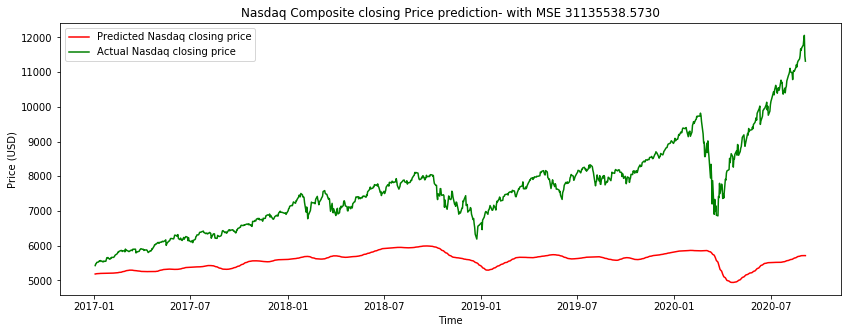

In [16]:
plt.figure(figsize = (14,5))
mse = mean_squared_error(y_test, predicted_price)
plt.plot(predicted_price['Nasdaq_predicted'], color = 'red', label = 'Predicted Nasdaq closing price')
plt.plot(test_data.Close['^IXIC'], color = 'green', label = 'Actual Nasdaq closing price')
plt.title ("Nasdaq Composite closing Price prediction- with MSE {:10.4f}".format(mse))
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()

Here, it can be seen that out network architecture is able to pick-up the hidden trend in the data; however, the accuracy is not that great at this stage and with right parameters, the accuracy can be improved considerably.
Similarly, other series can also be predicted selecting the right scale for chosen the series.